# Importando e tratando os dados

In [1]:
!pip install numpy pandas seaborn matplotlib statsmodels statsforecast scikit-learn prophet xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ferramentas de análise exploratória
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# modelos
from statsmodels.tsa.arima.model import ARIMA
from statsforecast.models import AutoARIMA
from prophet import Prophet
import xgboost as xgb

from prophet.plot import plot_plotly as prophet_plot

In [3]:
# Carregando os dados do arquivo CSV
df = pd.read_csv('dados_ibovespa.csv', sep=',', thousands='.', parse_dates=[0], date_format='%d.%m.%Y')
df

Data  Último  Abertura  Máxima  Mínima     Vol.    Var%
0    2024-07-22  127860    127616  128151  127456    6,10B   0,19%
1    2024-07-19  127616    127652  128360  127413    7,62B  -0,03%
2    2024-07-18  127652    129450  129454  127523    7,59B  -1,39%
3    2024-07-17  129450    129112  129658  128741    6,67B   0,26%
4    2024-07-16  129110    129322  129521  128761    6,82B  -0,16%
...         ...     ...       ...     ...     ...      ...     ...
4948 2004-07-28   22168     21740   22213   21613  285,65M   1,98%
4949 2004-07-27   21737     21325   21813   21236  282,56M   1,97%
4950 2004-07-26   21318     21635   21930   21056  227,13M  -1,26%
4951 2004-07-23   21591     21729   22100   21559  318,00M  -0,64%
4952 2004-07-22   21730     21821   21938   21490  247,83M  -0,37%

[4953 rows x 7 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      4953 non-null   datetime64[ns]
 1   Último    4953 non-null   int64         
 2   Abertura  4953 non-null   int64         
 3   Máxima    4953 non-null   int64         
 4   Mínima    4953 non-null   int64         
 5   Vol.      4952 non-null   object        
 6   Var%      4953 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 271.0+ KB


In [5]:
# Lista de nomes das colunas desejados
column_names = ['data', 'fechamento','abertura', 'maxima', 'minima', 'volume', 'variacao']

# Renomeando as colunas
df.columns = column_names
df.head()

data  fechamento  abertura  maxima  minima volume variacao
0 2024-07-22      127860    127616  128151  127456  6,10B    0,19%
1 2024-07-19      127616    127652  128360  127413  7,62B   -0,03%
2 2024-07-18      127652    129450  129454  127523  7,59B   -1,39%
3 2024-07-17      129450    129112  129658  128741  6,67B    0,26%
4 2024-07-16      129110    129322  129521  128761  6,82B   -0,16%

In [6]:
# Tratando volume - removendo letras e substituir vírgula por ponto
df['volume'] = df['volume'].str.replace('B', 'e9').str.replace('M', 'e6').str.replace('K','e3').str.replace(',', '.')

# Convertendo para numérico
df['volume'] = pd.to_numeric(df['volume'])

df.head()

data  fechamento  abertura  maxima  minima        volume variacao
0 2024-07-22      127860    127616  128151  127456  6.100000e+09    0,19%
1 2024-07-19      127616    127652  128360  127413  7.620000e+09   -0,03%
2 2024-07-18      127652    129450  129454  127523  7.590000e+09   -1,39%
3 2024-07-17      129450    129112  129658  128741  6.670000e+09    0,26%
4 2024-07-16      129110    129322  129521  128761  6.820000e+09   -0,16%

In [7]:
# Tratando variação - Removendo o símbolo de porcentagem e converter para float
df['variacao'] = df['variacao'].str.replace('%', '').str.replace(',', '.').astype(float)

df.head()

data  fechamento  abertura  maxima  minima        volume  variacao
0 2024-07-22      127860    127616  128151  127456  6.100000e+09      0.19
1 2024-07-19      127616    127652  128360  127413  7.620000e+09     -0.03
2 2024-07-18      127652    129450  129454  127523  7.590000e+09     -1.39
3 2024-07-17      129450    129112  129658  128741  6.670000e+09      0.26
4 2024-07-16      129110    129322  129521  128761  6.820000e+09     -0.16

In [8]:
# Ordenando os dados pela data em ordem crescrente
df = df.sort_values('data').reset_index(drop=True)
df.head()

data  fechamento  abertura  maxima  minima       volume  variacao
0 2004-07-22       21730     21821   21938   21490  247830000.0     -0.37
1 2004-07-23       21591     21729   22100   21559  318000000.0     -0.64
2 2004-07-26       21318     21635   21930   21056  227130000.0     -1.26
3 2004-07-27       21737     21325   21813   21236  282560000.0      1.97
4 2004-07-28       22168     21740   22213   21613  285650000.0      1.98

In [9]:
df.tail()

data  fechamento  abertura  maxima  minima        volume  variacao
4948 2024-07-16      129110    129322  129521  128761  6.820000e+09     -0.16
4949 2024-07-17      129450    129112  129658  128741  6.670000e+09      0.26
4950 2024-07-18      127652    129450  129454  127523  7.590000e+09     -1.39
4951 2024-07-19      127616    127652  128360  127413  7.620000e+09     -0.03
4952 2024-07-22      127860    127616  128151  127456  6.100000e+09      0.19

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        4953 non-null   datetime64[ns]
 1   fechamento  4953 non-null   int64         
 2   abertura    4953 non-null   int64         
 3   maxima      4953 non-null   int64         
 4   minima      4953 non-null   int64         
 5   volume      4952 non-null   float64       
 6   variacao    4953 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 271.0 KB


In [11]:
# convertendo data em índice
df = df.set_index('data')

df.head()

fechamento  abertura  maxima  minima       volume  variacao
data                                                                   
2004-07-22       21730     21821   21938   21490  247830000.0     -0.37
2004-07-23       21591     21729   22100   21559  318000000.0     -0.64
2004-07-26       21318     21635   21930   21056  227130000.0     -1.26
2004-07-27       21737     21325   21813   21236  282560000.0      1.97
2004-07-28       22168     21740   22213   21613  285650000.0      1.98

In [15]:
# Filtrando os dados
start_date = pd.to_datetime('2021-07-22')  # Data a partir da qual queremos as previsões

df = df[df.index >= start_date]
df

fechamento  abertura  maxima  minima        volume  variacao
data                                                                    
2021-07-22      126147    125930  126428  125416  6.480000e+06      0.17
2021-07-23      125053    126140  126204  124422  6.050000e+06     -0.87
2021-07-26      126004    125058  126214  125006  6.330000e+06      0.76
2021-07-27      124612    126004  126026  123670  7.310000e+06     -1.10
2021-07-28      126286    124615  126712  124542  9.040000e+06      1.34
...                ...       ...     ...     ...           ...       ...
2024-07-16      129110    129322  129521  128761  6.820000e+09     -0.16
2024-07-17      129450    129112  129658  128741  6.670000e+09      0.26
2024-07-18      127652    129450  129454  127523  7.590000e+09     -1.39
2024-07-19      127616    127652  128360  127413  7.620000e+09     -0.03
2024-07-22      127860    127616  128151  127456  6.100000e+09      0.19

[749 rows x 6 columns]

# Análise Exploratória dos Dados

## Passo 1: Visualização dos dados

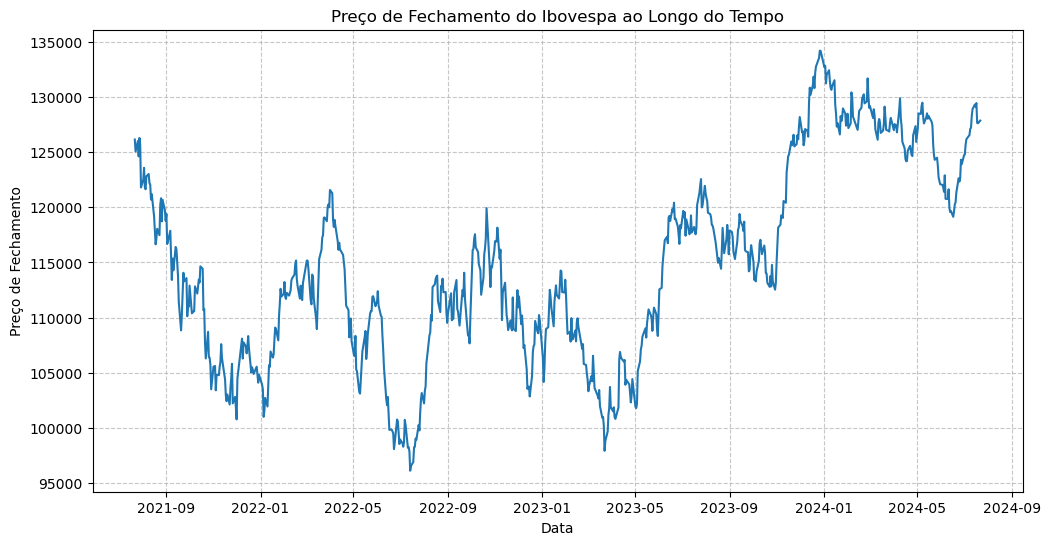

In [16]:
# Gráfico de linha do preço de fechamento ao longo do tempo

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['fechamento'], linestyle='-')
plt.title('Preço de Fechamento do Ibovespa ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.grid(alpha=0.7, linestyle='--')
plt.show()

### Visualização das estatísticas rolantes

In [17]:
# Estatísticas rolantes
rolmean = df['fechamento'].rolling(window=12).mean()
rolstd = df['fechamento'].rolling(window=12).std()

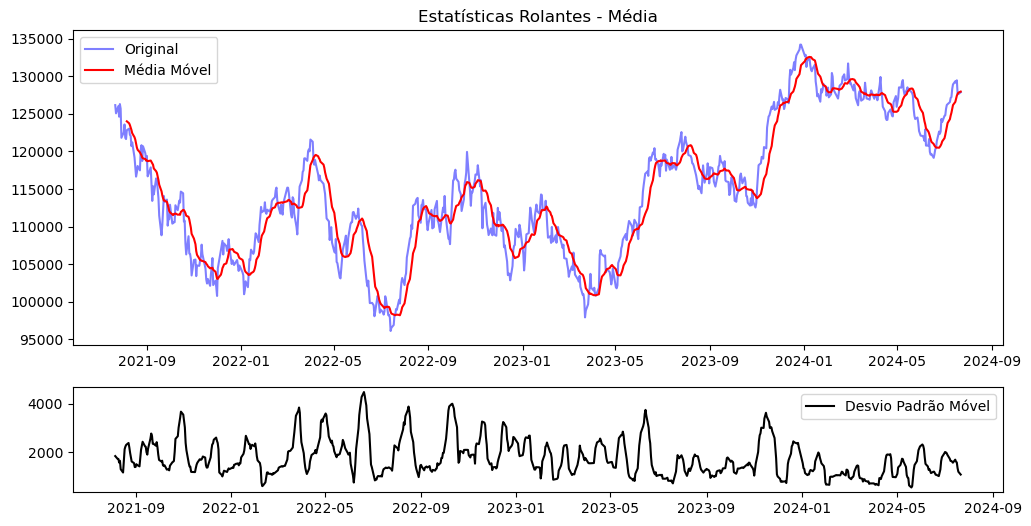

In [18]:
# Plot das estatísticas rolantes
fig = plt.figure(figsize=(12, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0])
ax1.plot(df['fechamento'], color='blue', label='Original', alpha=0.5)
ax1.plot(rolmean, color='red', label='Média Móvel')
ax1.legend(loc='best')
ax1.set_title('Estatísticas Rolantes - Média')

ax2 = fig.add_subplot(gs[1])
ax2.plot(rolstd, color='black', label='Desvio Padrão Móvel')
ax2.legend(loc='best')

plt.show()

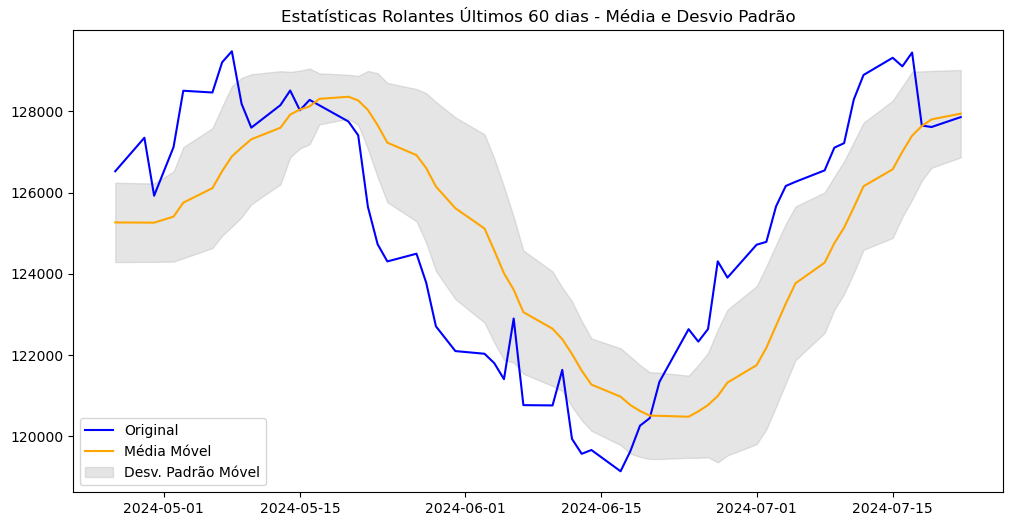

In [19]:
# Estatísticas Rolantes Últimos 60 dias

recent_days = 60

df_recent = df['fechamento'][-recent_days:]
rolmean_recent = rolmean[-recent_days:]
rolstd_recent = rolstd[-recent_days:]

# Plot das estatísticas rolantes últimos 60 dias
plt.figure(figsize=(12, 6))
plt.plot(df_recent, color='blue', label='Original')
plt.plot(rolmean_recent, color='orange', label='Média Móvel')
plt.fill_between(df_recent.index, (rolmean_recent - rolstd_recent), (rolmean_recent + rolstd_recent), color='gray', alpha=0.2, label='Desv. Padrão Móvel')

plt.legend(loc='best')
plt.title('Estatísticas Rolantes Últimos 60 dias - Média e Desvio Padrão')
plt.show()

### Decomposição da Série Temporal

In [20]:
timeseries_decompose = seasonal_decompose(df['fechamento'], model='additive', period=30)  # Exemplo de período sazonal de 30 dias

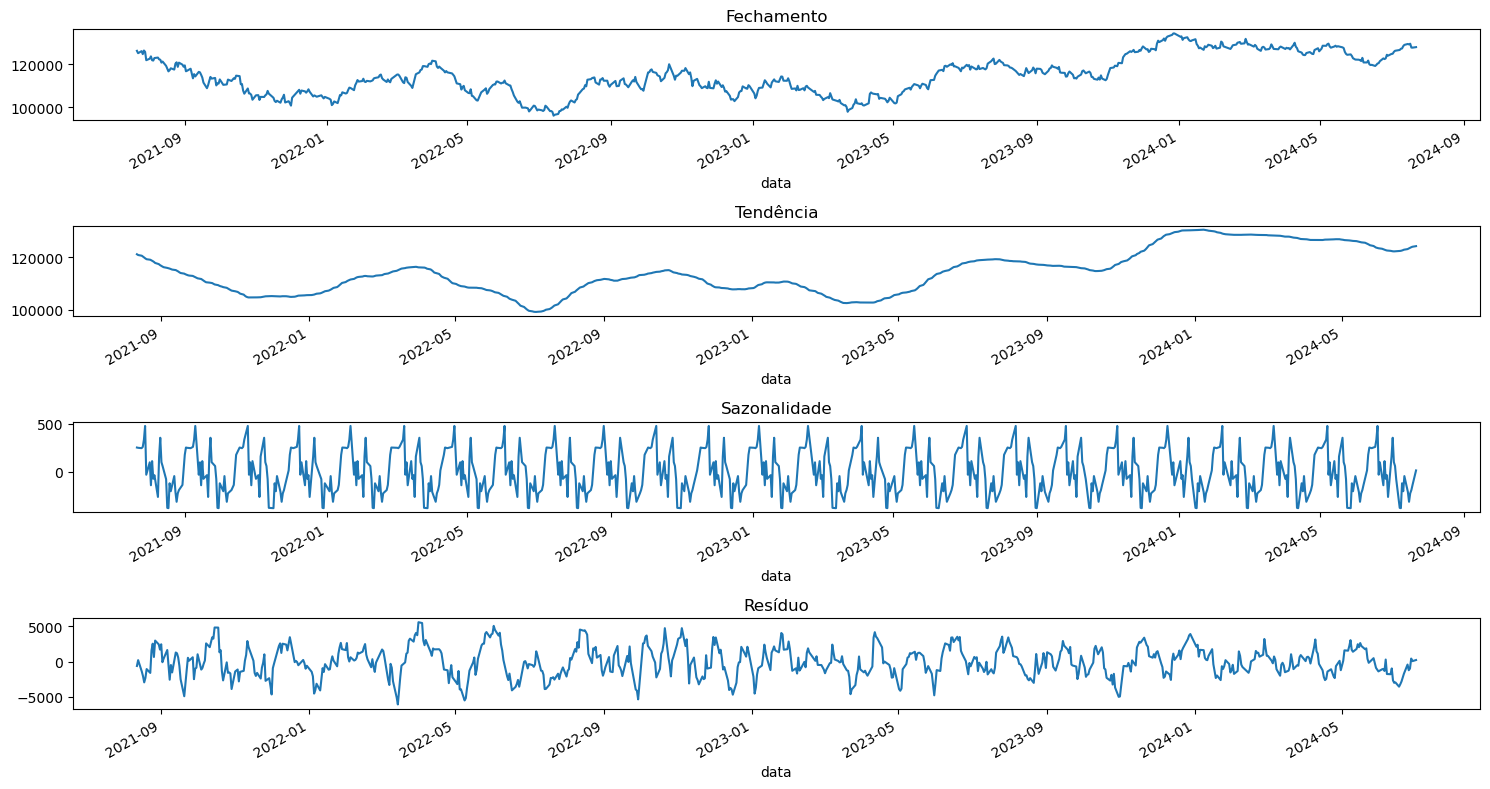

In [21]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))

timeseries_decompose.observed.plot(ax = ax1, title='Fechamento')

#tendencia
timeseries_decompose.trend.plot(ax = ax2, title='Tendência')

#sazonalidade
timeseries_decompose.seasonal.plot(ax = ax3, title='Sazonalidade')

#residuo dos dados
timeseries_decompose.resid.plot(ax = ax4, title='Resíduo')

plt.tight_layout()

## Passo 2: Testes de estacionariedade e sazonalidade

### Teste de Estacionariedade

In [22]:
# Teste de Dickey-Fuller
print('Resultados do Teste de Dickey-Fuller:')
df_adftest = adfuller(df['fechamento'], autolag='AIC')
dfoutput = pd.Series(df_adftest[0:4], index=['Estatística do Teste', 'Valor-p', 'Número de Lags Usados', 'Número de Observações Usadas'])
for key, value in df_adftest[4].items():
    dfoutput['Valor Crítico (%s)' % key] = value
print(dfoutput)

# Verificar o valor-p e imprimir o resultado do teste de estacionariedade
if df_adftest[1] > 0.05:
    print("H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)")
else:
    print("H1 - HIPOTESE ALTERNATIVA (REJEIÇÃO DA HIPOTESE NULA, OU SEJA, É ESTACIONÁRIA)")

Resultados do Teste de Dickey-Fuller:
Estatística do Teste             -1.972615
Valor-p                           0.298708
Número de Lags Usados             0.000000
Número de Observações Usadas    748.000000
Valor Crítico (1%)               -3.439123
Valor Crítico (5%)               -2.865412
Valor Crítico (10%)              -2.568832
dtype: float64
H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)


### Teste de Sazonalidade

In [23]:
#TESTE DE SAZONALIDADE

# Separar os dados por períodos sazonais
groups = [group[1]['fechamento'].values for group in df.groupby(df.index.month)]

# Aplicar o teste de Fisher
statistic, p= stats.f_oneway(*groups)

# Imprimir o valor-p
print(f'Valor-p do teste de Fisher: {p:.4f}')

if p > 0.05:
  print("Não há evidencia suficiente para rejeitar a hipotese de sazonalidade")
else:
  print("A hipotese de sazonalidade é rejeitada")

Valor-p do teste de Fisher: 0.3094
Não há evidencia suficiente para rejeitar a hipotese de sazonalidade


### Análise dos Resultados

- Estatística do Teste (ADF): -1.222467

A estatística do teste de Dickey-Fuller é significativamente maior que os valores críticos em todos os níveis de significância (1%, 5%, 10%). Isso indica que não temos evidências estatísticas suficientes para rejeitar a hipótese nula de que a série possui uma raiz unitária, ou seja, podemos considerar a série como não estacionária, ou seja, apresenta tendências claras, sazonalidades ou variações que dependam do tempo.

- Valor-p: 0.68

O valor-p é não é pequeno (0.68), ou seja, 68% significativamente maior que qualquer nível de significância comum, algo em torno de 5% (0.05). Isso reforça ainda mais a conclusão de que a série não é estacionária.

#### Conclusão

Com base nos resultados do teste, podemos concluir que a série temporal do preço de fechamento do Ibovespa não é estacionária. A estatística do teste de ADF é maior que os valores críticos correspondentes e o valor-p alto, comparado com o nivel de signficancia comum (5%), indicando que há raiz unitária na série e que ela não é estacionária.

Portanto, podemos **proceder com confiança para modelagem e previsão usando métodos adequados para séries temporais como ARIMA** por exemplo.

# Predição

## Passo 1: Preparação dos Dados e Modelagem

In [24]:
df_modeling = df[['fechamento', 'abertura']]
df_modeling

fechamento  abertura
data                            
2021-07-22      126147    125930
2021-07-23      125053    126140
2021-07-26      126004    125058
2021-07-27      124612    126004
2021-07-28      126286    124615
...                ...       ...
2024-07-16      129110    129322
2024-07-17      129450    129112
2024-07-18      127652    129450
2024-07-19      127616    127652
2024-07-22      127860    127616

[749 rows x 2 columns]

In [25]:
df_modeling.shape

(749, 2)

In [26]:
## Dividindo dados em treino e teste

test_size = 30
train_size = df_modeling.shape[0] - test_size
train = df_modeling[:train_size]
test = df_modeling[train_size:]

In [27]:
train

fechamento  abertura
data                            
2021-07-22      126147    125930
2021-07-23      125053    126140
2021-07-26      126004    125058
2021-07-27      124612    126004
2021-07-28      126286    124615
...                ...       ...
2024-06-04      121802    122032
2024-06-05      121407    121803
2024-06-06      122899    121408
2024-06-07      120767    122899
2024-06-10      120760    120769

[719 rows x 2 columns]

In [28]:
test.head()

fechamento  abertura
data                            
2024-06-11      121635    120760
2024-06-12      119936    121644
2024-06-13      119568    119936
2024-06-14      119662    119558
2024-06-17      119138    119663

In [29]:
test.tail()

fechamento  abertura
data                            
2024-07-16      129110    129322
2024-07-17      129450    129112
2024-07-18      127652    129450
2024-07-19      127616    127652
2024-07-22      127860    127616

In [30]:
train.shape

(719, 2)

In [31]:
test.shape

(30, 2)

## Passo 2: Métricas de avaliação dos modelos

In [32]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(model, metrics):
    mae, mse, mape = metrics
    print(f'{model} Metrics:')
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

## Passo 2: Treinando e avaliando modelos

### ARIMA

In [74]:
# Preparando dados de treino para ARIMA
train_arima = train[['fechamento']].copy()
train_arima = train_arima.asfreq('B') 
train_arima.tail()

fechamento
data                  
2024-06-04    121802.0
2024-06-05    121407.0
2024-06-06    122899.0
2024-06-07    120767.0
2024-06-10    120760.0

In [75]:
# Preparando dados de teste para ARIMA
test_arima = test[['fechamento']].copy()
test_arima = test_arima.asfreq('B') 
test_arima.head()

fechamento
data                  
2024-06-11      121635
2024-06-12      119936
2024-06-13      119568
2024-06-14      119662
2024-06-17      119138

In [78]:
# Ajustando o modelo ARIMA
model_arima = ARIMA(train_arima, order=(5, 1, 0))
model_arima_fit = model_arima.fit()

In [79]:
# Fazendo previsões
predict_arima = model_arima_fit.predict(start=len(train_arima), end=len(train_arima) + len(test_arima) - 1)

In [80]:
predict_arima

2024-06-11    120739.468299
2024-06-12    120781.362625
2024-06-13    120731.512749
2024-06-14    120768.098225
2024-06-17    120767.077664
2024-06-18    120768.459099
2024-06-19    120766.858737
2024-06-20    120768.143985
2024-06-21    120767.486974
2024-06-24    120767.544642
2024-06-25    120767.489429
2024-06-26    120767.537322
2024-06-27    120767.507050
2024-06-28    120767.519695
2024-07-01    120767.517456
2024-07-02    120767.519253
2024-07-03    120767.517970
2024-07-04    120767.518661
2024-07-05    120767.518396
2024-07-08    120767.518470
2024-07-09    120767.518418
2024-07-10    120767.518451
2024-07-11    120767.518435
2024-07-12    120767.518441
2024-07-15    120767.518439
2024-07-16    120767.518440
2024-07-17    120767.518439
2024-07-18    120767.518440
2024-07-19    120767.518439
2024-07-22    120767.518440
Freq: B, Name: predicted_mean, dtype: float64

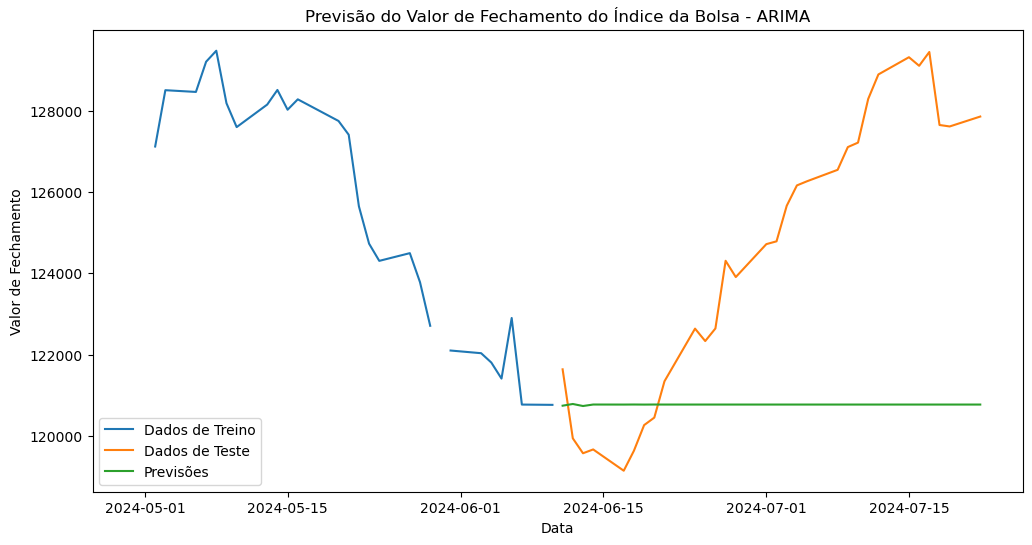

In [81]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(train_arima[-test_size:], label='Dados de Treino')
plt.plot(test_arima.index, test_arima, label='Dados de Teste')
plt.plot(test_arima.index, predict_arima, label='Previsões')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

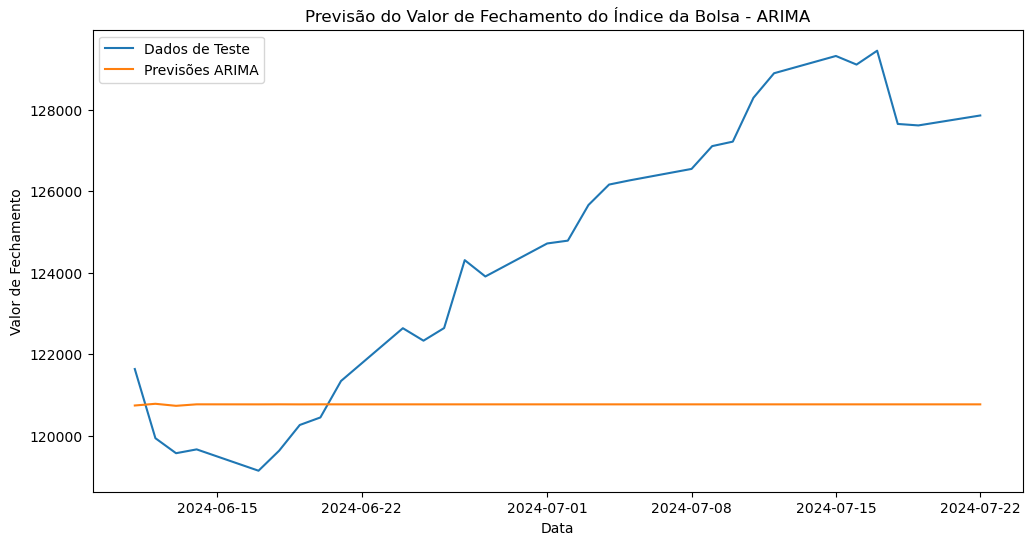

In [82]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(test_arima.index, test_arima, label='Dados de Teste')
plt.plot(test_arima.index, predict_arima, label='Previsões ARIMA')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [83]:
metrics_arima = calculate_metrics(test_arima.values, predict_arima)
print_metrics('ARIMA', metrics_arima)

ARIMA Metrics:
MAE: 4151.9221694193775
MSE: 25212143.739148848
MAPE: 3.277876330042369


### AutoARIMA

In [85]:
# Preparando dados de treino para AutoARIMA
train_autoarima = train.copy()
train_autoarima = train_autoarima.reset_index()
train_autoarima = train_autoarima.rename(columns={"data": "ds", "fechamento": "y"})
train_autoarima['unique_id'] = 'Bolsa de Valores'
train_autoarima.tail()

ds       y  abertura         unique_id
714 2024-06-04  121802    122032  Bolsa de Valores
715 2024-06-05  121407    121803  Bolsa de Valores
716 2024-06-06  122899    121408  Bolsa de Valores
717 2024-06-07  120767    122899  Bolsa de Valores
718 2024-06-10  120760    120769  Bolsa de Valores

In [86]:
# Preparando dados de teste para AutoARIMA
test_autoarima = test.copy()
test_autoarima = test_autoarima.reset_index()
test_autoarima = test_autoarima.rename(columns={"data": "ds", "fechamento": "y"})
test_autoarima['unique_id'] = 'Bolsa de Valores'
test_autoarima.head()

ds       y  abertura         unique_id
0 2024-06-11  121635    120760  Bolsa de Valores
1 2024-06-12  119936    121644  Bolsa de Valores
2 2024-06-13  119568    119936  Bolsa de Valores
3 2024-06-14  119662    119558  Bolsa de Valores
4 2024-06-17  119138    119663  Bolsa de Valores

In [87]:
X_df_autorima = test_autoarima[['ds', 'abertura', 'unique_id']]
X_df_autorima.head()

ds  abertura         unique_id
0 2024-06-11    120760  Bolsa de Valores
1 2024-06-12    121644  Bolsa de Valores
2 2024-06-13    119936  Bolsa de Valores
3 2024-06-14    119558  Bolsa de Valores
4 2024-06-17    119663  Bolsa de Valores

In [88]:
model_autoarima = StatsForecast(models=[AutoARIMA(season_length=1)], freq='B',n_jobs=-1) # season_length=1 (sem sazonalidade) freq='B' (dias úteis - business days)
model_autoarima.fit(train_autoarima)
predict_autoarima = model_autoarima.predict(h=test_size, level = [90], X_df = X_df_autorima) # h=test_size, level=[90] (nível de confiança)
predict_autoarima.tail()

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


ds      AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90
unique_id                                                                   
Bolsa de Valores 2024-07-16  120880.328125    109717.312500    132043.343750
Bolsa de Valores 2024-07-17  120877.375000    109501.710938    132253.046875
Bolsa de Valores 2024-07-18  120882.132812    109297.718750    132466.546875
Bolsa de Valores 2024-07-19  120856.835938    109067.375000    132646.296875
Bolsa de Valores 2024-07-22  120856.328125    108865.320312    132847.328125

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsforecast/core.py:1447: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


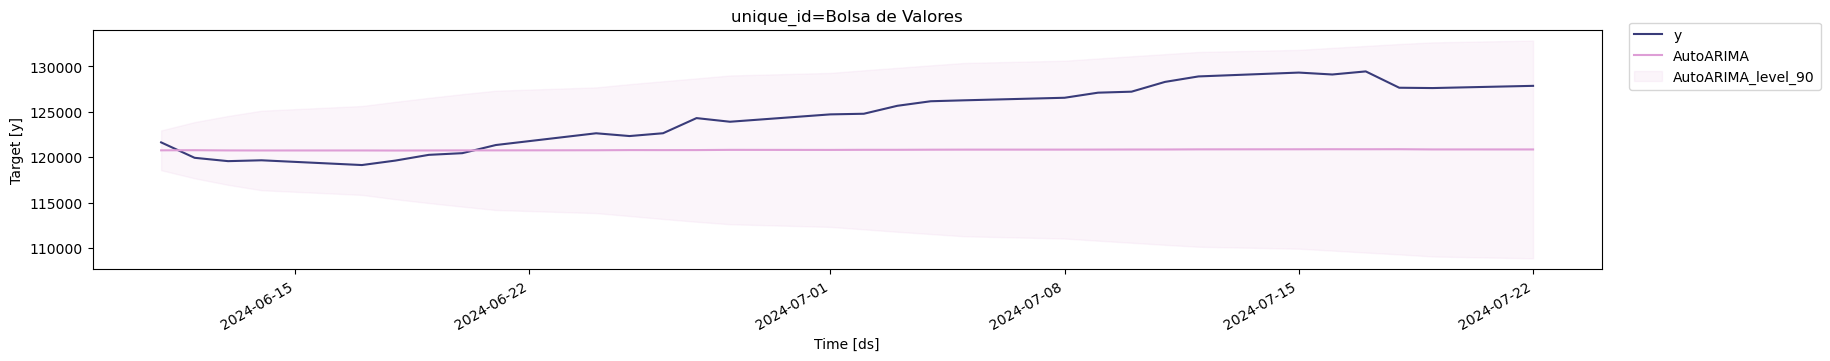

In [91]:
model_autoarima.plot(test_autoarima, predict_autoarima, level = [90], unique_ids = ['Bolsa de Valores'], engine = 'matplotlib')

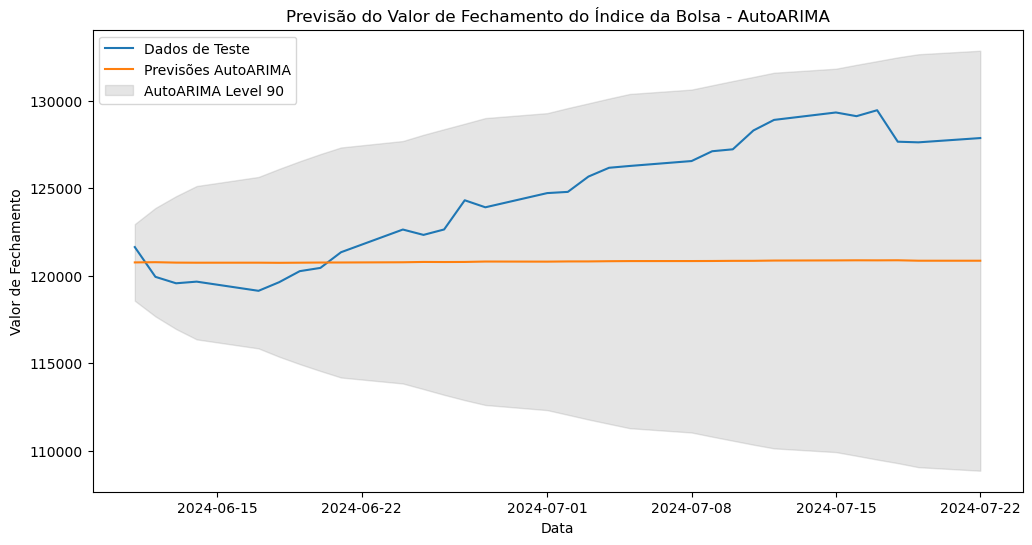

In [92]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(test_autoarima['ds'], test_autoarima['y'], label='Dados de Teste')
plt.plot(predict_autoarima['ds'], predict_autoarima['AutoARIMA'], label='Previsões AutoARIMA')
plt.fill_between(predict_autoarima['ds'], predict_autoarima['AutoARIMA-lo-90'], predict_autoarima['AutoARIMA-hi-90'], color='gray', alpha=0.2, label='AutoARIMA Level 90')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - AutoARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='upper left')
plt.show()

In [93]:
metrics_autoarima = calculate_metrics(test_autoarima['y'].values, predict_autoarima['AutoARIMA'].values)
print_metrics('AutoARIMA', metrics_autoarima)

AutoARIMA Metrics:
MAE: 4101.737760416667
MSE: 24594597.6788798
MAPE: 3.2382882017005183


### Prophet

In [94]:
# Preparando dados de treino para o Prophet
train_prophet = train.copy()
train_prophet = train_prophet.reset_index()
train_prophet = train_prophet.rename(columns={'data': 'ds', 'fechamento': 'y'})
train_prophet.head()

ds       y  abertura
0 2021-07-22  126147    125930
1 2021-07-23  125053    126140
2 2021-07-26  126004    125058
3 2021-07-27  124612    126004
4 2021-07-28  126286    124615

In [96]:
# Preparando dados de teste para o Prophet
test_prophet = test.copy()
test_prophet = test_prophet.reset_index()
test_prophet = test_prophet.rename(columns={'data': 'ds', 'fechamento': 'y'})
test_prophet

ds       y  abertura
0  2024-06-11  121635    120760
1  2024-06-12  119936    121644
2  2024-06-13  119568    119936
3  2024-06-14  119662    119558
4  2024-06-17  119138    119663
5  2024-06-18  119630    119138
6  2024-06-19  120261    119630
7  2024-06-20  120446    120267
8  2024-06-21  121341    120446
9  2024-06-24  122637    121343
10 2024-06-25  122331    122634
11 2024-06-26  122641    122331
12 2024-06-27  124308    122642
13 2024-06-28  123907    124308
14 2024-07-01  124718    123905
15 2024-07-02  124787    124720
16 2024-07-03  125662    124787
17 2024-07-04  126164    125666
18 2024-07-05  126267    126165
19 2024-07-08  126548    126280
20 2024-07-09  127108    126548
21 2024-07-10  127218    127109
22 2024-07-11  128294    127221
23 2024-07-12  128897    128293
24 2024-07-15  129321    128898
25 2024-07-16  129110    129322
26 2024-07-17  129450    129112
27 2024-07-18  127652    129450
28 2024-07-19  127616    127652
29 2024-07-22  127860    127616

In [97]:
model_prophet = Prophet(weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False)

model_prophet.add_country_holidays(country_name='BR')
model_prophet.add_regressor('abertura')

model_prophet.fit(train_prophet)

future_prophet= model_prophet.make_future_dataframe(periods=test_size, freq='B') # freq='B' (dias úteis - business days)
future_prophet['abertura'] = pd.concat([train_prophet['abertura'], test_prophet['abertura'], test_prophet['abertura']], ignore_index=True)

predict_prophet = model_prophet.predict(future_prophet)
predict_prophet.sort_values(by='ds')

10:08:08 - cmdstanpy - INFO - Chain [1] start processing
10:08:08 - cmdstanpy - INFO - Chain [1] done processing


ds          trend     yhat_lower     yhat_upper    trend_lower  \
0   2021-07-22  114154.809980  123781.293671  127148.680152  114154.809980   
1   2021-07-23  114153.264419  123873.786188  127276.951769  114153.264419   
2   2021-07-26  114148.627736  122977.718672  126356.832924  114148.627736   
3   2021-07-27  114147.082175  123976.701827  127304.761981  114147.082175   
4   2021-07-28  114145.536614  122611.785663  125872.761649  114145.536614   
..         ...            ...            ...            ...            ...   
744 2024-07-16  114760.831561  127481.259717  130754.778248  114747.262323   
745 2024-07-17  114760.788962  127347.647580  130623.467239  114746.241096   
746 2024-07-18  114760.746362  127653.840828  130818.132557  114745.549245   
747 2024-07-19  114760.703763  125918.020608  129335.026746  114744.267365   
748 2024-07-22  114760.575965  125932.167696  129272.186023  114742.604981   

       trend_upper  Confraternização Universal  \
0    114154.809980                         0.0   
1    114153.264419                         0.0   
2    114148.627736                         0.0   
3    114147.082175                         0.0   
4    114145.536614                         0.0   
..             ...                         ...   
744  114774.883751                         0.0   
745  114776.014884                         0.0   
746  114777.508861                         0.0   
747  114778.699802                         0.0   
748  114780.268063                         0.0   

     Confraternização Universal_lower  Confraternização Universal_upper  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               0.0   
..                                ...                               ...   
744                               0.0                               0.0   
745                               0.0                               0.0   
746                               0.0                               0.0   
747                               0.0                               0.0   
748                               0.0                               0.0   

     Dia Nacional de Zumbi e da Consciência Negra  ...  holidays  \
0                                             0.0  ...       0.0   
1                                             0.0  ...       0.0   
2                                             0.0  ...       0.0   
3                                             0.0  ...       0.0   
4                                             0.0  ...       0.0   
..                                            ...  ...       ...   
744                                           0.0  ...       0.0   
745                                           0.0  ...       0.0   
746                                           0.0  ...       0.0   
747                                           0.0  ...       0.0   
748                                           0.0  ...       0.0   

     holidays_lower  holidays_upper      yearly  yearly_lower  yearly_upper  \
0               0.0             0.0  164.476389    164.476389    164.476389   
1               0.0             0.0  186.011197    186.011197    186.011197   
2               0.0             0.0  226.975822    226.975822    226.975822   
3               0.0             0.0  232.844919    232.844919    232.844919   
4               0.0             0.0  235.091804    235.091804    235.091804   
..              ...             ...         ...           ...           ...   
744             0.0             0.0  -21.848615    -21.848615    -21.848615   
745             0.0             0.0   16.336869     16.336869     16.336869   
746             0.0             0.0   52.7129

In [98]:
model_prophet.train_holiday_names

0                      Confraternização Universal
1                               Sexta-feira Santa
2                                      Tiradentes
3                              Dia do Trabalhador
4                         Independência do Brasil
5                         Nossa Senhora Aparecida
6                                         Finados
7                        Proclamação da República
8    Dia Nacional de Zumbi e da Consciência Negra
9                                           Natal
dtype: object

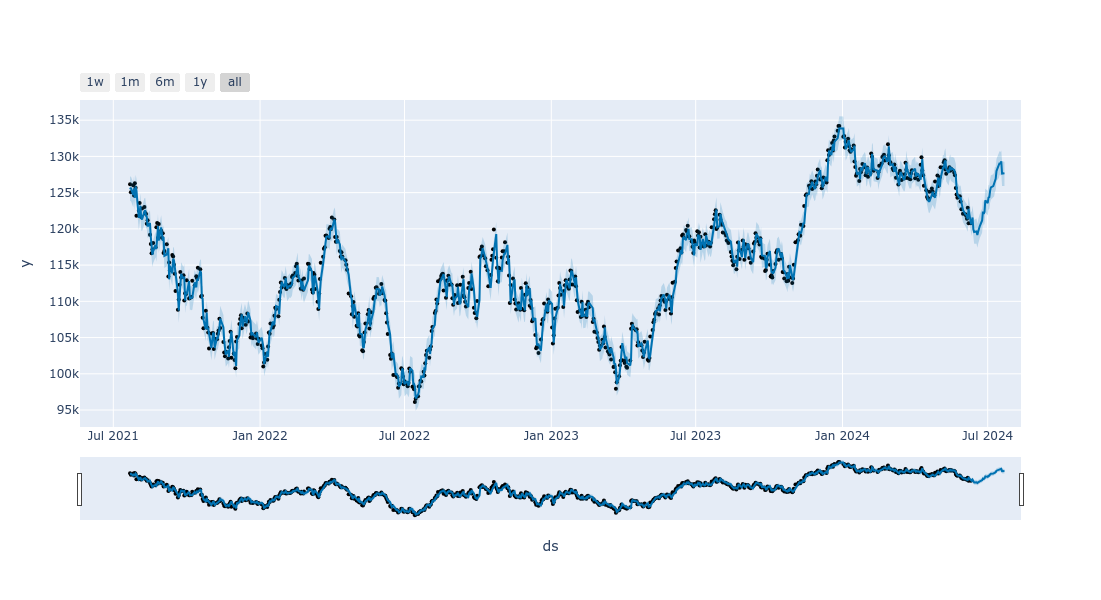

In [99]:
prophet_plot(model_prophet, predict_prophet)

In [100]:
predict_prophet_test = predict_prophet.tail(test_size)[['ds', 'yhat']].reset_index(drop=True)
predict_prophet_test.tail()

ds           yhat
25 2024-07-16  129125.183944
26 2024-07-17  128962.075586
27 2024-07-18  129322.327708
28 2024-07-19  127633.211276
29 2024-07-22  127682.069863

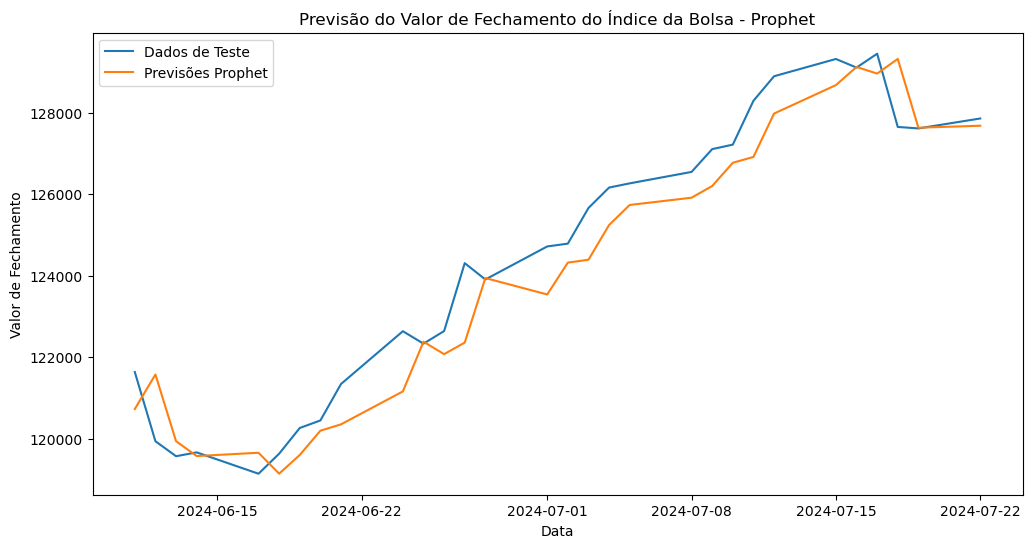

In [101]:
# Visualizando as previsões do modelo Prophet
plt.figure(figsize=(12, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Dados de Teste')
plt.plot(predict_prophet_test['ds'], predict_prophet_test['yhat'], label='Previsões Prophet')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - Prophet')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [102]:
metrics_prophet = calculate_metrics(test_prophet['y'].values, predict_prophet_test['yhat'].values)
print_metrics('Prophet', metrics_prophet)

Prophet Metrics:
MAE: 721.726602776514
MSE: 797992.2703369397
MAPE: 0.5798129867462333


### Testando Possível Overfitting do Prophet

In [104]:
# Filtrar previsões para o período de treinamento e teste
predict_prophet_train = predict_prophet[predict_prophet['ds'] < '2024-06-11']
predict_prophet_train

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0   2021-07-22  114154.809980  123781.293671  127148.680152  114154.809980   
1   2021-07-23  114153.264419  123873.786188  127276.951769  114153.264419   
2   2021-07-26  114148.627736  122977.718672  126356.832924  114148.627736   
3   2021-07-27  114147.082175  123976.701827  127304.761981  114147.082175   
4   2021-07-28  114145.536614  122611.785663  125872.761649  114145.536614   
..         ...            ...            ...            ...            ...   
714 2024-06-04  114762.620733  120104.242296  123575.504191  114762.620733   
715 2024-06-05  114762.578134  119934.782562  123392.794300  114762.578134   
716 2024-06-06  114762.535535  119602.444994  122991.671561  114762.535535   
717 2024-06-07  114762.492935  121192.416386  124442.281487  114762.492935   
718 2024-06-10  114762.365137  119114.033338  122482.256975  114762.365137   

       trend_upper  Confraternização Universal  \
0    114154.809980                         0.0   
1    114153.264419                         0.0   
2    114148.627736                         0.0   
3    114147.082175                         0.0   
4    114145.536614                         0.0   
..             ...                         ...   
714  114762.620733                         0.0   
715  114762.578134                         0.0   
716  114762.535535                         0.0   
717  114762.492935                         0.0   
718  114762.365137                         0.0   

     Confraternização Universal_lower  Confraternização Universal_upper  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               0.0   
..                                ...                               ...   
714                               0.0                               0.0   
715                               0.0                               0.0   
716                               0.0                               0.0   
717                               0.0                               0.0   
718                               0.0                               0.0   

     Dia Nacional de Zumbi e da Consciência Negra  ...  holidays  \
0                                             0.0  ...       0.0   
1                                             0.0  ...       0.0   
2                                             0.0  ...       0.0   
3                                             0.0  ...       0.0   
4                                             0.0  ...       0.0   
..                                            ...  ...       ...   
714                                           0.0  ...       0.0   
715                                           0.0  ...       0.0   
716                                           0.0  ...       0.0   
717                                           0.0  ...       0.0   
718                                           0.0  ...       0.0   

     holidays_lower  holidays_upper      yearly  yearly_lower  yearly_upper  \
0               0.0             0.0  164.476389    164.476389    164.476389   
1               0.0             0.0  186.011197    186.011197    186.011197   
2               0.0             0.0  226.975822    226.975822    226.975822   
3               0.0             0.0  232.844919    232.844919    232.844919   
4               0.0             0.0  235.091804    235.091804    235.091804   
..              ...             ...         ...           ...           ...   
714             0.0             0.0 -224.411707   -224.411707   -224.411707   
715             0.0             0.0 -226.512648   -226.512648   -226.512648   
716             0.0             0.0 -226.7536

#### Testando Overfitting

In [106]:
# Supondo que você tenha previsões para treinamento e teste
mape_train = np.abs((train_prophet['y'] - predict_prophet_train['yhat']) / train_prophet['y']).mean() * 100
mape_test = np.abs((test_prophet['y'] - predict_prophet_test['yhat']) / test_prophet['y']).mean() * 100

print(f"MAPE nos Dados de Treinamento: {mape_train:.2f}%")
print(f"MAPE nos Dados de Teste: {mape_test:.2f}%")

MAPE nos Dados de Treinamento: 0.90%
MAPE nos Dados de Teste: 0.58%


#### Conclusão

O fato de o MAPE nos dados de teste ser menor do que nos dados de treinamento não é comum e **não é um sinal típico de overfitting**. 


Overfitting geralmente é indicado por um MAPE muito baixo em dados de treinamento e um MAPE significativamente maior em dados de teste. Nesse caso, o MAPE em dados de teste é menor, o que pode indicar que o modelo está generalizando bem e, possivelmente, foi ajustado de forma robusta.

### XGBoost

In [107]:
# Preparando dados de treino para o XGBoost
train_xgb = train.copy()
train_xgb = train_xgb.reset_index()
train_xgb['ano'] = train_xgb['data'].dt.year
train_xgb['mes'] = train_xgb['data'].dt.month
train_xgb['dia'] = train_xgb['data'].dt.day
train_xgb['diadasemana'] = train_xgb['data'].dt.dayofweek
train_xgb.tail()

data  fechamento  abertura   ano  mes  dia  diadasemana
714 2024-06-04      121802    122032  2024    6    4            1
715 2024-06-05      121407    121803  2024    6    5            2
716 2024-06-06      122899    121408  2024    6    6            3
717 2024-06-07      120767    122899  2024    6    7            4
718 2024-06-10      120760    120769  2024    6   10            0

In [109]:
# Preparando dados de treino para o XGBoost
test_xgb = test.copy()
test_xgb = test_xgb.reset_index()
test_xgb['ano'] = test_xgb['data'].dt.year
test_xgb['mes'] = test_xgb['data'].dt.month
test_xgb['dia'] = test_xgb['data'].dt.day
test_xgb['diadasemana'] = test_xgb['data'].dt.dayofweek
test_xgb

data  fechamento  abertura   ano  mes  dia  diadasemana
0  2024-06-11      121635    120760  2024    6   11            1
1  2024-06-12      119936    121644  2024    6   12            2
2  2024-06-13      119568    119936  2024    6   13            3
3  2024-06-14      119662    119558  2024    6   14            4
4  2024-06-17      119138    119663  2024    6   17            0
5  2024-06-18      119630    119138  2024    6   18            1
6  2024-06-19      120261    119630  2024    6   19            2
7  2024-06-20      120446    120267  2024    6   20            3
8  2024-06-21      121341    120446  2024    6   21            4
9  2024-06-24      122637    121343  2024    6   24            0
10 2024-06-25      122331    122634  2024    6   25            1
11 2024-06-26      122641    122331  2024    6   26            2
12 2024-06-27      124308    122642  2024    6   27            3
13 2024-06-28      123907    124308  2024    6   28            4
14 2024-07-01      124718    123905  2024    7    1            0
15 2024-07-02      124787    124720  2024    7    2            1
16 2024-07-03      125662    124787  2024    7    3            2
17 2024-07-04      126164    125666  2024    7    4            3
18 2024-07-05      126267    126165  2024    7    5            4
19 2024-07-08      126548    126280  2024    7    8            0
20 2024-07-09      127108    126548  2024    7    9            1
21 2024-07-10      127218    127109  2024    7   10            2
22 2024-07-11      128294    127221  2024    7   11            3
23 2024-07-12      128897    128293  2024    7   12            4
24 2024-07-15      129321    128898  2024    7   15            0
25 2024-07-16      129110    129322  2024    7   16            1
26 2024-07-17      129450    129112  2024    7   17            2
27 2024-07-18      127652    129450  2024    7   18            3
28 2024-07-19      127616    127652  2024    7   19            4
29 2024-07-22      127860    127616  2024    7   22            0

In [110]:
FEATURES = ['ano', 'mes', 'dia', 'diadasemana', 'abertura']
TARGET = 'fechamento'

X_train_xgb, y_train_xgb = train_xgb[FEATURES], train_xgb[TARGET]
X_test_xgb, y_test_xgb = test_xgb[FEATURES], test_xgb[TARGET]

reg = xgb.XGBRegressor(objective='reg:squarederror')
reg.fit(X_train_xgb, y_train_xgb)

# Avaliação XGBoost
predict_xgb = reg.predict(X_test_xgb)
predict_xgb

array([120656.85 , 122282.375, 119784.5  , 118682.95 , 119775.12 ,
       118460.1  , 120170.164, 120535.5  , 120021.79 , 121797.016,
       121842.94 , 122042.516, 121005.03 , 124313.055, 124648.62 ,
       125615.26 , 125985.3  , 125697.06 , 127000.44 , 127798.68 ,
       128489.32 , 126993.195, 126914.4  , 127750.23 , 129190.14 ,
       129230.49 , 128783.13 , 128282.58 , 127290.42 , 126997.97 ],
      dtype=float32)

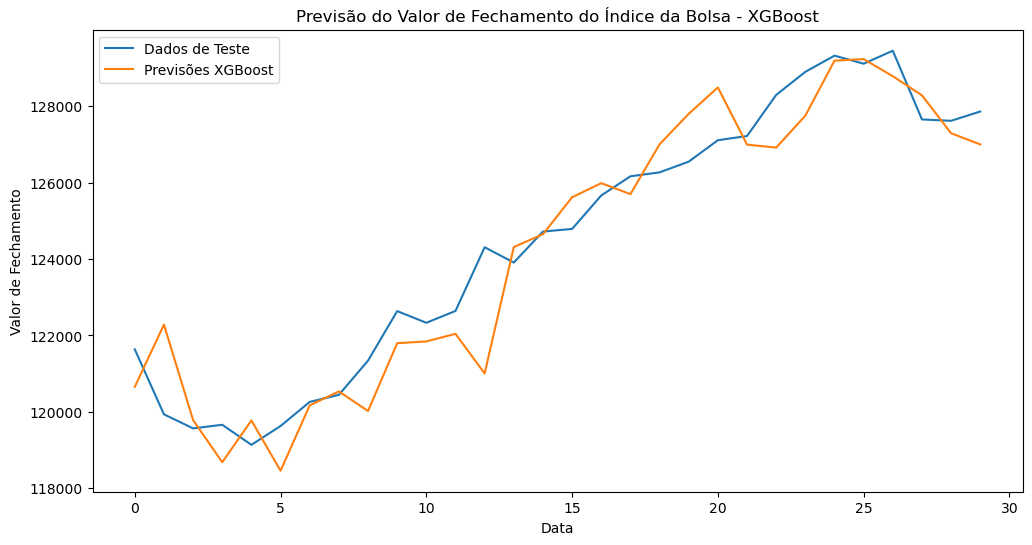

In [111]:
# Visualizando as previsões do modelo XGBoost
plt.figure(figsize=(12, 6))
plt.plot(X_test_xgb.index, y_test_xgb, label='Dados de Teste')
plt.plot(X_test_xgb.index, predict_xgb, label='Previsões XGBoost')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - XGBoost')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [112]:
metrics_xgb = calculate_metrics(y_test_xgb, predict_xgb)
print_metrics('XGBoost', metrics_xgb)

XGBoost Metrics:
MAE: 800.1028645833334
MSE: 1113027.3837137858
MAPE: 0.6447850369191079


## Passo 3: Comparando os modelos

In [113]:
df_metrics = pd.DataFrame(
    [metrics_arima, metrics_autoarima, metrics_prophet, metrics_xgb],
    columns=['MAE', 'MSE', 'MAPE'],
    index=['ARIMA', 'AutoARIMA', 'Prophet', 'XGBoost'],
)
df_metrics

MAE           MSE      MAPE
ARIMA      4151.922169  2.521214e+07  3.277876
AutoARIMA  4101.737760  2.459460e+07  3.238288
Prophet     721.726603  7.979923e+05  0.579813
XGBoost     800.102865  1.113027e+06  0.644785